# Overview

Ini adalah project Text Classification sebagai Task untuk kandidat Jr. Data Scientist di PT. Atmatech Global Informatika.

Pada project ini saya menggunakan data teks berupa post/status media sosial yang dikumpulkan dari berbagai source (twitter, kaskus, dll). Terima kasih untuk IndoNLP dan akun GitHub ahmadizzan telah membagikan data ini. (Data dapat diakses [di sini](https://github.com/ahmadizzan/netifier)).

## Jenis Klasifikasi
Jenis klasifikasi yang saya pilih untuk project ini adalah klasifikasi biner.

## Model
Model yang saya pilih untuk digunakan dalam project ini adalah model Logistic Regression. Saya memilih model ini dibandingkan neural network karena untuk saat ini saya lebih menguasai Logistic Regression dan saya lebih percaya diri dengan kemampuan saya tentang model ini.

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import Datasets

In [ ]:
train_raw = pd.read_csv('/content/gdrive/My Drive/DS Project/Atmatech/data/train.csv')
test_raw = pd.read_csv('/content/gdrive/My Drive/DS Project/Atmatech/data/test.csv')

In [ ]:
# data train overview
train_raw.sample(5)

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik
6834,"@fashionlucintaluna... kasihan sekali ya kamu,...",instagram,0,0,0,0
5396,Video burem tutur kata sma mimik mulut kemana ...,instagram,0,0,0,1
5602,BOKEP MP3 MEMEK HOT SEKS KONTOL: BOKEP MP3 MEM...,twitter,1,0,0,0
6583,bangkitkan dendam d besar2kan to pembenaran sa...,twitter,1,0,0,0
2343,@aidarosalina semog kalo suatu saat suami mbak...,instagram,0,0,0,0


In [ ]:
# data test overview
test_raw.sample(5)

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik
585,Idiot anjing memeq lo...jahanam...lahir hasil ...,kaskus,1,1,0,1
526,"Indonesia yg mengaku,ketuhanan yg maha esa dan...",twitter,0,1,1,1
412,Orang yang mengubah ciptaan Allah ia akan mend...,instagram,0,0,0,0
261,pace semu putih » RT: @RendyNoorAvie: Pantes p...,twitter,0,0,0,0
87,@hobibelanja12 saya tkw singapore saya kalo.tu...,instagram,0,0,0,0


# Preprocessing

## Remove Duplicates

Pada tahap ini dilakukan penghapusan baris-baris duplikat untuk mengurangi bias pada model ataupun mengurangi kemungkinan overfitting.

In [ ]:
# Copy datasets
train_prep = train_raw.copy()
test_prep = test_raw.copy()

In [ ]:
# Check Dupliates
print('jumlah duplikat data train:', train_prep.duplicated().sum())
print('jumlah duplikat data test:', test_prep.duplicated().sum())

jumlah duplikat data train: 593
jumlah duplikat data test: 27


In [ ]:
# Remove Duplicates
train_no_dup = train_prep.drop_duplicates()
test_no_dup = test_prep.drop_duplicates()

In [ ]:
train_no_dup = train_no_dup[train_no_dup['original_text'].duplicated() == False]
test_no_dup = test_no_dup[test_no_dup['original_text'].duplicated() == False]

In [ ]:
train_no_dup = train_no_dup.reset_index(drop = True)
test_no_dup = test_no_dup.reset_index(drop = True)

In [ ]:
# Check Dupliates
print('jumlah duplikat data train:', train_no_dup.duplicated().sum())
print('jumlah duplikat data test:', test_no_dup.duplicated().sum())

jumlah duplikat data train: 0
jumlah duplikat data test: 0


## Extract Labels

Karena project ini menggunakan klasifikasi biner, maka label akan di summary agar hanya terdapat dua jenis (1 untuk Negative, dan 0 untuk Not Negative). Sampel yang memenuhi minimal 1 aspek negatif dari 4 aspek yang direkam (pornografi, sara, radikalisme, dan pencemaran nama baik) diklasifikasikan sebagai Negative. Sedangkan sampel yang tidak memenuhi semua aspek negatif akan diklasifikasikan sebagai Not Negative.

In [ ]:
# train data
train_labeled = train_no_dup.copy()
train_labeled['labels'] = train_labeled.drop(columns = ['original_text', 'source']).apply(sum, axis = 1)
train_labeled['labels'] = train_labeled['labels'].apply(lambda x: 0 if x == 0 else 1)

# test data
test_labeled = test_no_dup.copy()
test_labeled['labels'] = test_labeled.drop(columns = ['original_text', 'source']).apply(sum, axis = 1)
test_labeled['labels'] = test_labeled['labels'].apply(lambda x: 0 if x == 0 else 1)

## Split into X and y sets

Untuk keperluan preprocessing khusus data text, saya terlebih dahulu memisahkan antara fitur (X) dengan label (y)

In [ ]:
X_train = train_labeled['original_text']
y_train = train_labeled['labels']
X_test = test_labeled['original_text']
y_test = test_labeled['labels']

In [ ]:
# Overview
X_train[:5]

0    [QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...
1    @verosvante kita2 aja nitizen yang pada kepo,t...
2    "#SidangAhok smg sipenista agama n ateknya mat...
3    @bolususulembang.jkt barusan baca undang2 ini....
4    bikin anak mulu lu nof \nkaga mikir apa kasian...
Name: original_text, dtype: object

In [ ]:
X_test[:5]

0    1.BUKAN CM SPANDUK PROF,VIDEO2 ORASI MEREKA, B...
1    @memeqbeceq gy sange'gatel yh tetek'memekY drn...
2    Pertama kali denger lagunya enk bgt in dan png...
3    astajim, ini pasti yg kasih penghargaan ke ibu...
4    beda kalo disini kalo komplain lgs di bully am...
Name: original_text, dtype: object

In [ ]:
y_train[:5]

0    1
1    0
2    1
3    0
4    0
Name: labels, dtype: int64

In [ ]:
y_test[:5]

0    1
1    1
2    0
3    0
4    0
Name: labels, dtype: int64

## Lowercasing

Tahap ini bertujuan untuk mengubah semua sampel (teks) menjadi huruf kecil. Hal ini dilakukan agar program tidak mengenali dua atau lebih kata yang bermakna sama sebagai hal yang berbeda, misalnya 'Membutuhkan' dengan 'memButuhkan'.

In [ ]:
def lowercase(data):
  lower_text = []
  for sentence in data:
    lower = str.lower(sentence)
    lower_text.append(lower)
  return lower_text

Xtr_lower = lowercase(X_train)
Xts_lower = lowercase(X_test)

## Remove New Line Tag (\n)

Tahap ini bertujuan untuk menghilangkan tanda \n.

In [ ]:
def rep_newline(data):
  newlines = []
  for sentence in data:
    newline = sentence.replace("\\n", " ")
    newline = newline.replace("\n", " ")
    newlines.append(newline)
  return newlines

Xtr_lower = rep_newline(Xtr_lower)
Xts_lower = rep_newline(Xts_lower)

In [ ]:
Xtr_lower[:2]

['[quote=jessepinkman16;5a50ac34d89b093f368b456e]jabar emng propinsi barokah :lehuga[/quote]  woi, anjing goblok propinsi yang paling banyak ngerusak dan ngebakar gereja itu jatim, gak lu sebut propinsi lumbung nasbung tuh jatim? propinsi penghasil gembong teroris terbanyak itu jateng, gak lu sebut lumbung nasbung tuh jateng? ngarang stereotip kok piliah pilih? banggsat lu pecun ',
 '@verosvante kita2 aja nitizen yang pada kepo,toh keluarga besar pasti udh pada tau,situ jg kalo urusan nya diurusin orang pasti ngamuk2,ngedumel "ngasih makan engga sibuk ngurusin urusan gw"yakan?setiap orang pnya cara masng2 buat mensyukuri kebahagiaannya ,ada yg di publis ada yg disimpen yg pntng tujuannya apa!trus kalo soal hijrahnya karna habib ya berarti allah ngasih jalannya lewat situ,kan jalan hijrah manusia itu msng2 pintunya ,jgn so tau makanya']

## Remove Kaskus Formatting

Tahap ini bertujuan untuk menghapus format dari kaskus

In [ ]:
def rmv_kaskus(data):
  clean_texts = []
  for sentence in data:
    clean = re.sub('\[', ' [', sentence)
    clean = re.sub('\]', '] ', clean)
    clean = re.sub('\[quote[^ ]*\].*?\[\/quote\]', ' ', clean)
    clean = re.sub('\[[^ ]*\]', ' ', clean)
    clean = re.sub('&quot;', ' ', clean)
    clean_texts.append(clean)
  return clean_texts

In [ ]:
Xtr_nokaskus = rmv_kaskus(Xtr_lower)
Xts_nokaskus = rmv_kaskus(Xts_lower)

## Remove Twitter and IG Formatting
Tahap ini bertujuan untuk menghapus format dari twitter dan instagram

In [ ]:
def rmv_twitter(data):
  clean_texts = []
  for sentence in data:
    clean = re.sub(r'@[A-Za-z0-9]+', '', sentence)
    clean = re.sub(r'\brt\b', '', clean)
    clean_texts.append(clean)
  return clean_texts

In [ ]:
Xtr_notwitter = rmv_twitter(Xtr_nokaskus)
Xts_notwitter = rmv_twitter(Xts_nokaskus)

## Remove URL

Tahap ini bertujuan untuk menghilangkan URL dalam teks

In [ ]:
def rmv_url(data):
  no_url_texts = []
  for sentence in data:
    clean = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', sentence)
    no_url_texts.append(clean)
  return no_url_texts

In [ ]:
Xtr_nourl = rmv_url(Xtr_notwitter)
Xts_nourl = rmv_url(Xts_notwitter)

## Remove Additional Whitespaces

Tahap ini dilakukan dengan tujuan menghapus spasi/tab yang tidak diperlukan

In [ ]:
def rmv_whitespace(data):
  no_whitespace_texts = []
  for sentence in data:
    clean = re.sub('  +', ' ', sentence)
    no_whitespace_texts.append(clean)
  return no_whitespace_texts

In [ ]:
Xtr_nowhitespace = rmv_whitespace(Xtr_nourl)
Xts_nowhitespace = rmv_whitespace(Xts_nourl)

In [ ]:
Xtr_nowhitespace[0]

' woi, anjing goblok propinsi yang paling banyak ngerusak dan ngebakar gereja itu jatim, gak lu sebut propinsi lumbung nasbung tuh jatim? propinsi penghasil gembong teroris terbanyak itu jateng, gak lu sebut lumbung nasbung tuh jateng? ngarang stereotip kok piliah pilih? banggsat lu pecun '

## Remove Punctuation

Pada tahap ini dilakukan penghapusan tanda baca

In [ ]:
def rmv_punct(data):
  no_pnct_texts = []
  for sentence in data:
    clean = re.sub(r'[^\w\s]', ' ', sentence)
    no_pnct_texts.append(clean)
  return no_pnct_texts

In [ ]:
Xtr_nopnct = rmv_punct(Xtr_nowhitespace)
Xts_nopnct = rmv_punct(Xts_nowhitespace)

In [ ]:
Xtr_nopnct[0]

' woi  anjing goblok propinsi yang paling banyak ngerusak dan ngebakar gereja itu jatim  gak lu sebut propinsi lumbung nasbung tuh jatim  propinsi penghasil gembong teroris terbanyak itu jateng  gak lu sebut lumbung nasbung tuh jateng  ngarang stereotip kok piliah pilih  banggsat lu pecun '

## Replace Slang Words

Tahap ini bertujuan untuk mengganti kata-kata tidak formal menjadi kata formal

In [ ]:
slangs = pd.read_csv('/content/gdrive/My Drive/DS Project/Atmatech/data/slangword.csv')
##overview
slangs.sample(5)

,original,translated
501,kejurnas,kejuaraan nasional
1883,perfect,sempurna
1450,dlm,dalam
2121,skrang,sekarang
2334,tauladan,teladan


In [ ]:
slangs_dict = slangs.set_index('original').to_dict()
slangs_dict = slangs_dict['translated']

In [ ]:
def replace_slangs(text):
    word_list = text.split()
    word_list_len = len(word_list)
    transformed_word_list = []
    i = 0
    while i < word_list_len:
        if (i + 1) < word_list_len:
            two_words = ' '.join(word_list[i:i+2])
            if two_words in slangs_dict:
                transformed_word_list.append(slangs_dict[two_words])
                i += 2
                continue
        transformed_word_list.append(slangs_dict.get(word_list[i], word_list[i]))
        i += 1
    return ' '.join(transformed_word_list)

In [ ]:
Xtr_noslang = [replace_slangs(i) for i in tqdm(Xtr_nopnct)]
Xts_noslang = [replace_slangs(i) for i in tqdm(Xts_nopnct)]

  0%|          | 0/6371 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

In [ ]:
Xts_noslang[0]

'1 bukan cuma spanduk prof video2 orasi mereka buku2 mereka dan lain-lain itu sudah sngat jelas saya heran sama rkyat2 yang masih tolol sudah jls2 ada niat dari hizbut tahrir yang ingin tegakkan khilafah ganti negara kesatuan republik indonesia masih berkilah tidak ada lah mau tegakkan khilafah saja munafik apanya khilafah'

## Remove non Alphabeth

Menghapus karakter-karakter non alfabet

In [ ]:
def rmv_nonalphabeth(data):
  just_alphabeth = []
  for sentence in data:
    clean = re.sub('[^a-zA-Z ]+', '', sentence)
    just_alphabeth.append(clean)
  return just_alphabeth

In [ ]:
Xtr_alphabeth = rmv_nonalphabeth(Xtr_noslang)
Xts_alphabeth = rmv_nonalphabeth(Xts_noslang)

In [ ]:
Xts_alphabeth[1]

'gy sange gatel yh tetek memeky drnjng tempat tdr dkmr smbil telnjng bugil mntf banget itu bunda gde banget itu lebat tidak yh bulu jembut'

## Remove Repeating Characters

Menghapus karakter berulang (misal: 'halooooo' menajadi 'halo')

In [ ]:
import itertools
def rmv_repeat(data):
  no_repeat = []
  for sentence in data:
    clean = ''.join(''.join(s)[:1] for _, s in itertools.groupby(sentence))
    no_repeat.append(clean)
  return no_repeat

In [ ]:
Xtr_norepeat = rmv_repeat(Xtr_alphabeth)
Xts_norepeat = rmv_repeat(Xts_alphabeth)

## Tokenizing

tahap ini mengubah kalimat menjadi sekumpulan(list) token. Ini dilakukan untuk memudahkan menghapus stopwords

In [ ]:
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
Xtr_tok = [word_tokenize(i) for i in Xtr_norepeat]
Xts_tok = [word_tokenize(i) for i in Xts_norepeat]

In [ ]:
Xtr_tok[0]

['woi',
 'anjing',
 'bodoh',
 'provinsi',
 'yang',
 'paling',
 'banyak',
 'ngerusak',
 'dan',
 'ngebakar',
 'gereja',
 'itu',
 'jatim',
 'tidak',
 'kamu',
 'sebut',
 'provinsi',
 'lumbung',
 'nasbung',
 'itu',
 'jatim',
 'provinsi',
 'penghasil',
 'gembong',
 'teroris',
 'terbanyak',
 'itu',
 'jateng',
 'tidak',
 'kamu',
 'sebut',
 'lumbung',
 'nasbung',
 'itu',
 'jateng',
 'ngarang',
 'stereotip',
 'kok',
 'piliah',
 'pilih',
 'bangsat',
 'kamu',
 'pecun']

## Remove Stopwords

Menghapus stopwords

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def rmv_stopwords(data):
  removed = []
  for tokens in tqdm(data):
    nostop = []
    for token in tokens:
      if not token in set(stopwords.words('indonesian')):
        nostop.append(token)
    removed.append(nostop)
  return removed

In [ ]:
Xtr_nostops = rmv_stopwords(Xtr_tok)
Xts_nostops = rmv_stopwords(Xts_tok)

  0%|          | 0/6371 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

In [ ]:
Xtr_nostops[0]

['woi',
 'anjing',
 'bodoh',
 'provinsi',
 'ngerusak',
 'ngebakar',
 'gereja',
 'jatim',
 'provinsi',
 'lumbung',
 'nasbung',
 'jatim',
 'provinsi',
 'penghasil',
 'gembong',
 'teroris',
 'jateng',
 'lumbung',
 'nasbung',
 'jateng',
 'ngarang',
 'stereotip',
 'piliah',
 'pilih',
 'bangsat',
 'pecun']

## Join tokens

Menyatukan kembali token-token menjadi sebuah kalimat

In [ ]:
def join_tokens(data):
  joined = []
  for tokens in data:
    tokens = ' '.join(tokens)
    joined.append(tokens)
  return joined

In [ ]:
Xtr_join = join_tokens(Xtr_nostops)
Xts_join = join_tokens(Xts_nostops)

In [ ]:
Xtr_join[6]

'heh kontol jan sok pemes rp muka memek orang tua monyet agama aje agama kontol'

## Stemming

Menghapus imbuhan pada kata

In [ ]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 5.5 MB/s eta 0:00:00


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(data):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  stemmed_data = []
  for sentence in tqdm(data):
    stemmed_data.append(stemmer.stem(sentence))
  return stemmed_data

In [ ]:
Xtr_stem = stemming(Xtr_join)
Xts_stem = stemming(Xts_join)

  0%|          | 0/6371 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

In [ ]:
train_prep = pd.DataFrame()
train_prep['text'] = Xtr_stem
train_prep['label'] = y_train

test_prep = pd.DataFrame()
test_prep['text'] = Xts_stem
test_prep['label'] = y_test

In [ ]:
train_prep.to_csv('/content/gdrive/My Drive/DS Project/Atmatech/data/train_prep.csv', index = None)
test_prep.to_csv('/content/gdrive/My Drive/DS Project/Atmatech/data/test_prep.csv', index = None)

## Count Vertorizer

Tahap terakhir dari preprocessing adalah vektorisasi, ini bertujuan untuk mengubah data string menjadi numerik agar bisa dipahami oleh program komputer.

In [ ]:
data_train = pd.read_csv('/content/gdrive/My Drive/DS Project/Atmatech/data/train_prep.csv')
data_test = pd.read_csv('/content/gdrive/My Drive/DS Project/Atmatech/data/test_prep.csv')

In [ ]:
# Drop Missing
data_train = data_train.dropna().reset_index(drop = True)

In [ ]:
# Split into feature and target
X = data_train['text']
y = data_train['label']

X_test = data_test['text']
y_test = data_test['label']

In [ ]:
## Perform a train_test_split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)
X_train = X_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)

In [ ]:
# Perform Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
Xtrain_vect = vect.fit_transform(X_train)
Xval_vect = vect.transform(X_val)
Xtest_vect = vect.transform(X_test)

In [ ]:
Xtrain_vect = Xtrain_vect.toarray()
Xval_vect = Xval_vect.toarray()
Xtest_vect = Xtest_vect.toarray()

## Pipeline for New Inputs

In [ ]:
def preprocessing(inputs):
  clean_inputs = lowercase(inputs)
  clean_inputs = rep_newline(clean_inputs)
  clean_inputs = rmv_kaskus(clean_inputs)
  clean_inputs = rmv_twitter(clean_inputs)
  clean_inputs = rmv_url(clean_inputs)
  clean_inputs = rmv_whitespace(clean_inputs)
  clean_inputs = rmv_punct(clean_inputs)
  clean_inputs = [replace_slangs(i) for i in clean_inputs]
  clean_inputs = rmv_nonalphabeth(clean_inputs)
  clean_inputs = rmv_repeat(clean_inputs)
  clean_inputs = [word_tokenize(i) for i in clean_inputs]
  clean_inputs = rmv_stopwords(clean_inputs)
  clean_inputs = join_tokens(clean_inputs)
  clean_inputs = stemming(clean_inputs)
  clean_inputs = vect.transform(clean_inputs)
  clean_inputs = clean_inputs.toarray()

  return clean_inputs

# Modeling

## Define Model

Model regresi logistik didefinisikan dalam sebua objek/class. Dalam objek ini terdapat beberapa method seperti sigmoid untuk menghitung probabilitas dari output linear, compute_gradient untuk menghitung gradien dari fungsi cost, fit untuk melakukan update parameter menggunakan teknik gradient descent yang bertujuan untuk melatih model agar sesuai dengan data yang kita miliki, predict untuk melakukan prediksi, serta cost untuk menghitung cost.

In [ ]:
#Mendefinisikan objek Logistic Regression

class LogReg:
  def __init__(self, learning_rate = 0.01, n_iter = 100, early_stopping = True, tol = 1e-10, schedule_rate = 0.01):
    self.learning_rate = learning_rate
    self.n_iter = n_iter
    self.early_stopping = early_stopping
    self.tol = tol
    self.schedule_rate = schedule_rate
  
  def sigmoid(self, z):
    return 1 / (1 + np.exp(-z))

  def compute_gradient(self, X, y, W):
    m, n = X.shape
    z = np.dot(X, W)
    y_pred = self.sigmoid(z)
    dj_dw = np.dot(X.T, (y_pred-y))/len(Xval_vect)

    return dj_dw


  def fit(self, X_train, y_train, X_val = None, y_val = None):
    m, n = X_train.shape
    self.W = np.zeros((n,))
    self.J_hist = []

    # perform gradient descent
    for i in tqdm(range(self.n_iter)):
      dj_dw = self.compute_gradient(X_train, y_train, self.W)
      
      self.W = self.W - self.learning_rate * dj_dw

      self.learning_rate *= (1 / (1 + self.schedule_rate * i))

      if self.early_stopping and X_val is not None and y_val is not None:
        y_pred = self.predict(X_val)
        val_cost = self.cost(y_pred, y_val)
        self.J_hist.append(val_cost)
        if i > 0 and val_cost > prev_val_cost - self.tol:
          print(f'Early stopping after {i} iterations')
          break
        prev_val_cost = val_cost

  def predict(self, X_test):
    z = np.dot(X_test, self.W)
    y_pred = np.round(self.sigmoid(z))
    return y_pred

  def cost(self, y_pred, y_actual, eps = 1e-15):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return np.mean(-(y_actual * np.log(y_pred) + (1 - y_actual) * np.log(1 - y_pred)))

In [ ]:
#membuat instance dari LogReg
lr = LogReg()

## Train Model

In [ ]:
lr.fit(Xtrain_vect, y_train, Xval_vect, y_val)

  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping after 9 iterations


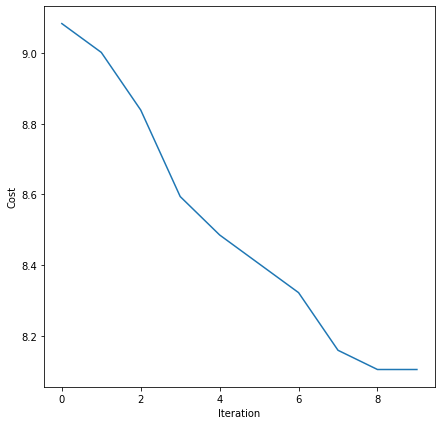

In [ ]:
# Plot Cost for Each Iter
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (7,7))
sns.lineplot(x = range(len(lr.J_hist)), y = lr.J_hist)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

## Model Evaluation
Setelah dilatih, model dievaluasi menggunakan metrik-metrik untuk kasus klasifikasi. Karena label yang dimiliki cukup balance dan kepentingan untuk kedua label sama, maka metrik utama yang kita perhatikan adalah akurasi.

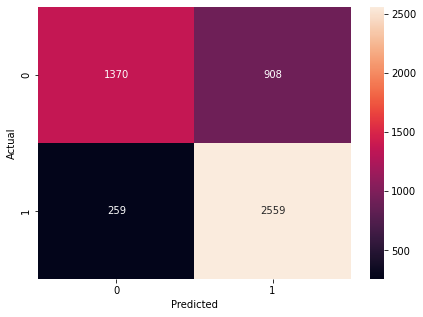

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Function for Drawing CM
def draw_cm(X, y):
  y_pred = lr.predict(X)
  cm = confusion_matrix(y, y_pred)

  plt.figure(figsize = (7,5))
  sns.heatmap(cm, annot = True, fmt = '.0f')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

# Draw Cm for train set
draw_cm(Xtrain_vect, y_train)

In [ ]:
# Classification report for train set
print(classification_report(y_train, lr.predict(Xtrain_vect)))

              precision    recall  f1-score   support

           0       0.84      0.60      0.70      2278
           1       0.74      0.91      0.81      2818

    accuracy                           0.77      5096
   macro avg       0.79      0.75      0.76      5096
weighted avg       0.78      0.77      0.76      5096



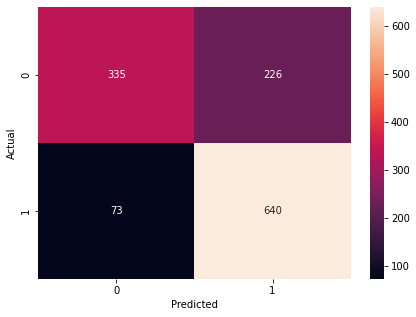

In [ ]:
# Draw Cm for val set
draw_cm(Xval_vect, y_val)

In [ ]:
# Classification report for val set
print(classification_report(y_val, lr.predict(Xval_vect)))

              precision    recall  f1-score   support

           0       0.82      0.60      0.69       561
           1       0.74      0.90      0.81       713

    accuracy                           0.77      1274
   macro avg       0.78      0.75      0.75      1274
weighted avg       0.78      0.77      0.76      1274



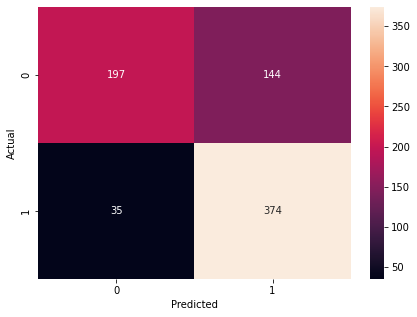

In [ ]:
# Draw Cm for test set
draw_cm(Xtest_vect, y_test)

In [ ]:
# Classification report for test set
print(classification_report(y_test, lr.predict(Xtest_vect)))

              precision    recall  f1-score   support

           0       0.85      0.58      0.69       341
           1       0.72      0.91      0.81       409

    accuracy                           0.76       750
   macro avg       0.79      0.75      0.75       750
weighted avg       0.78      0.76      0.75       750



Model tidak mengalami overfitting

## Export Model to Pickle

Model yang telah dilatih diekspor ke pickle untuk kebutuhan deployment.

In [ ]:
import pickle

In [ ]:
# Export model
with open('/content/gdrive/My Drive/DS Project/Atmatech/model_logreg.pickle', 'wb') as f:
  pickle.dump(lr, f)

In [ ]:
# Export Vectorizer
with open('/content/gdrive/My Drive/DS Project/Atmatech/vectorizer.pickle', 'wb') as f:
  pickle.dump(vect, f)

# Kesimpulan

Meskipun tidak mengalami overfitting, model Logistic Regression yang telah dilatih belum memiliki akurasi yang tinggi (<80%).

Tindak Lanjut: Karena dalam melatih model ini masih menggunakan teknik yang sangat sederhana, kedepannya bisa dilanjutkan menggunakan optimizer lain seperti L-BFGS sehingga diharapkan dapat meningkatkan sensitivitas model. Bisa juga menggunakan model-model dengan arsitektur yang lebih kompleks seperti neural network.